# Set up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchio as tio
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, sampler

# Load Data

In [2]:
NUM_TRAIN = 49000

train_data = pd.read_pickle('data/lung_cancer_train.pkl')
test_data = pd.read_pickle('data/lung_cancer_test.pkl')

train_data.head()

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."


# Preprocess

In [3]:
class LungRADSDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data['hu_array'])

    def __getitem__(self, idx):
        img = self.data['hu_array'].iloc[idx]
        mask = self.data['mask'].iloc[idx]

        # Add x and channel dimensions for grayscale images
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        if self.transform:
            img = self.transform(img)
        # mask = tio.Resize((1, 256, 256))(mask)  # Only if CUDA out of memory

        return img.squeeze(1), mask.squeeze(1) # (1, H, W)

In [4]:
# Transform pipeline
transform = tio.Compose([
    # tio.Resize((1, 256, 256)),                  # Only if CUDA out of memory
    tio.RescaleIntensity(percentiles=(0, 99)),  # Percentile stretching
    # tio.ZNormalization(),                       # Standardization
])

train_dataset = LungRADSDataset(train_data, transform=transform)
test_dataset = LungRADSDataset(test_data, transform=transform)

img, mask = train_dataset[0]
print(f'Image shape: {img.shape}, Mask shape: {mask.shape}')  # (B, C, H, W)

Image shape: torch.Size([1, 512, 512]), Mask shape: torch.Size([1, 512, 512])


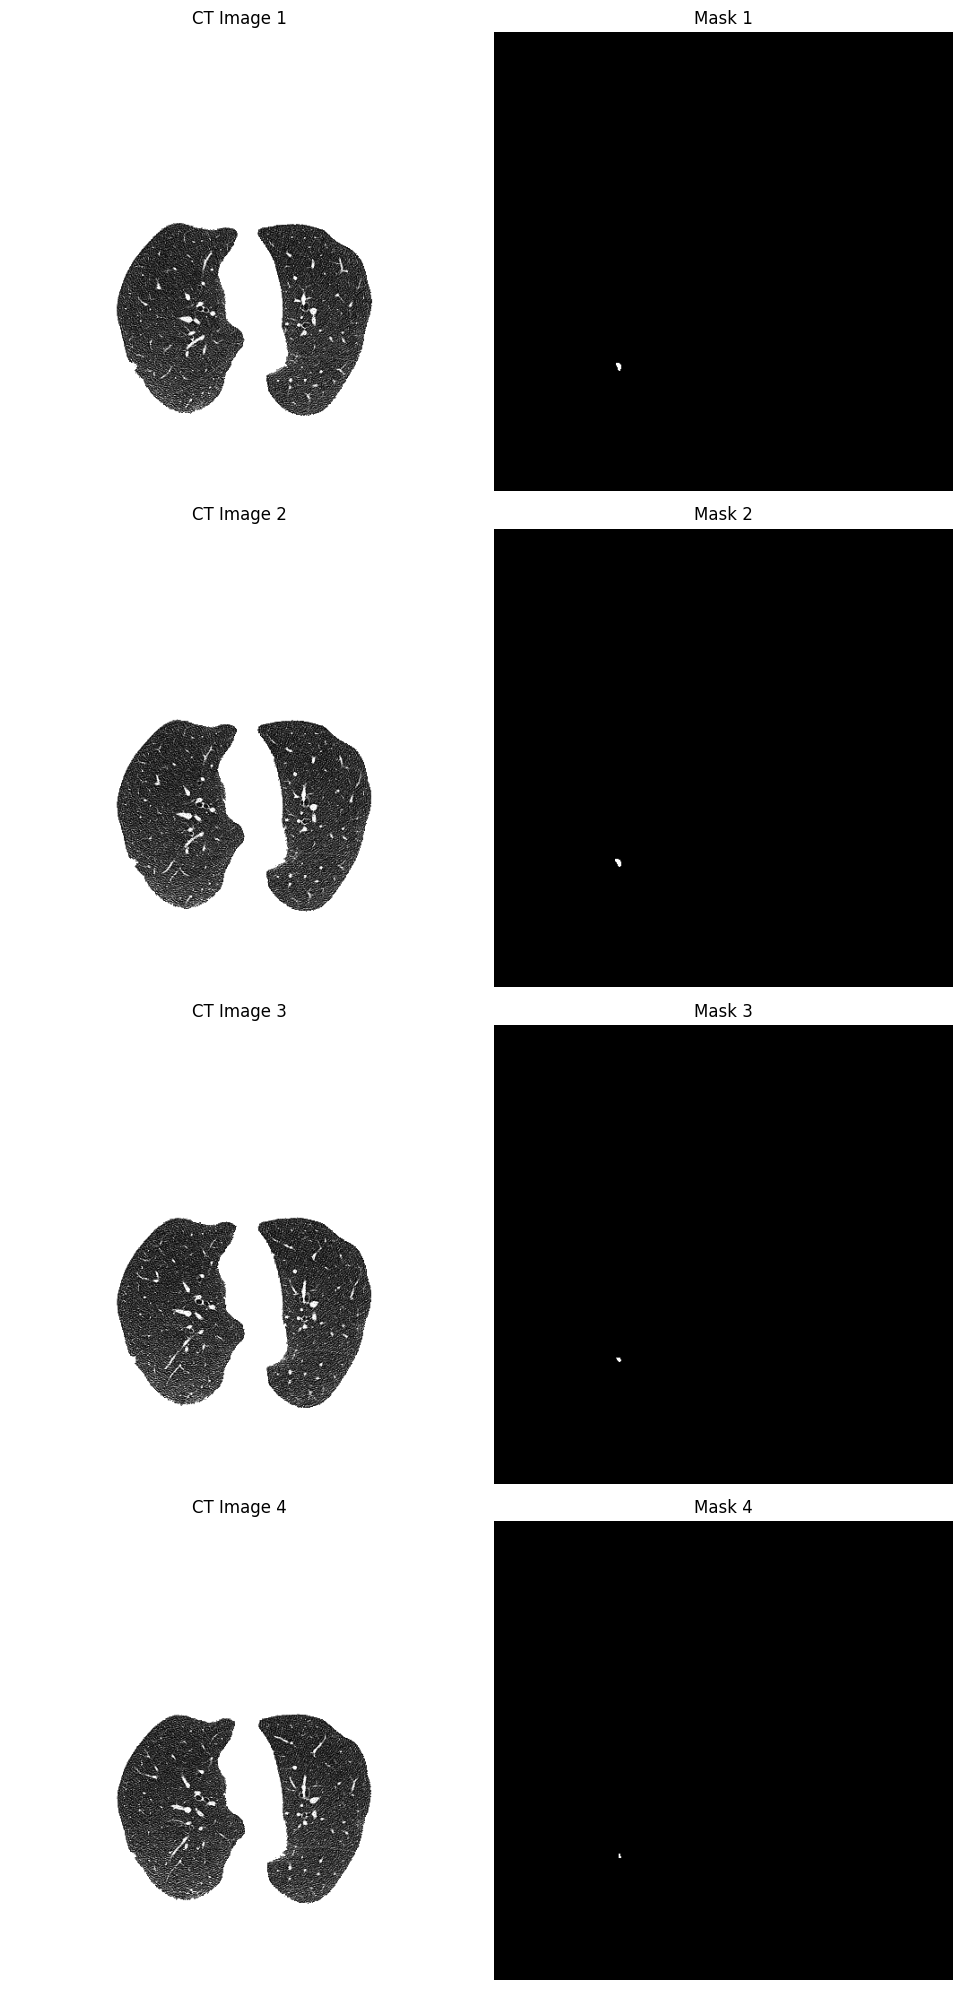

In [5]:
def plot_samples(dataset, num_samples=None):
    if num_samples is None:
        num_samples = len(dataset)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        img, mask = dataset[i]
        img = img.squeeze(0).cpu().numpy()
        mask = mask.squeeze(0).cpu().numpy()

        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'CT Image {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

plot_samples(train_dataset, num_samples=4)

# Modified UNet++

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.residual_conv = None

    def forward(self, x):
        x = x.float()
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.residual_conv:
            residual = self.residual_conv(residual)
        out += residual  # Add the residual connection
        out = self.relu(out)
        return out


class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(UNetPlusPlus, self).__init__()
        out_channels = [64, 128, 256, 512, 1024]

        # Backbone
        self.conv0_0 = ConvBlock(in_channels, out_channels[0], out_channels[0])
        self.conv1_0 = ConvBlock(out_channels[0], out_channels[1], out_channels[1])
        self.conv2_0 = ConvBlock(out_channels[1], out_channels[2], out_channels[2])
        self.conv3_0 = ConvBlock(out_channels[2], out_channels[3], out_channels[3])
        self.conv4_0 = ConvBlock(out_channels[3], out_channels[4], out_channels[4])

        # Skip pathways
        self.conv0_1 = ConvBlock(out_channels[0]+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_1 = ConvBlock(out_channels[1]+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_1 = ConvBlock(out_channels[2]+out_channels[3], out_channels[2], out_channels[2])
        self.conv3_1 = ConvBlock(out_channels[3]+out_channels[4], out_channels[3], out_channels[3])

        self.conv0_2 = ConvBlock(out_channels[0]*2+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_2 = ConvBlock(out_channels[1]*2+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_2 = ConvBlock(out_channels[2]*2+out_channels[3], out_channels[2], out_channels[2])

        self.conv0_3 = ConvBlock(out_channels[0]*3+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_3 = ConvBlock(out_channels[1]*3+out_channels[2], out_channels[1], out_channels[1])

        self.conv0_4 = ConvBlock(out_channels[0]*4 + out_channels[1], num_classes, 3)

        # Pooling and upsampling
        self.pool = nn.MaxPool2d(2, 2)
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Backbone
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Input = previous conv + upsample lower conv
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up_sample(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up_sample(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up_sample(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up_sample(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up_sample(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up_sample(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up_sample(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up_sample(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up_sample(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up_sample(x1_3)], 1))

        return x0_4

# Loss

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()

    def forward(self, predict, target):
        dice = 0
        classes = torch.unique(target)
        num_channels = target.shape[1]
        eps = torch.finfo(torch.float16).eps  # Change

        if len(classes) > 1:
            for class_ele in classes:
                class_val = class_ele.item()
                for c in range(num_channels):
                    pred_mask = (predict[:, c, :, :] == class_val).float().view(-1)
                    target_mask = (target == class_val).float().view(-1)
                    intersection = torch.sum(pred_mask * target_mask)
                    dice_class = 1 - 2 * intersection / (torch.sum(pred_mask) + torch.sum(target_mask) + eps)
                    dice += dice_class

        return dice/len(classes)


class DiceCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, class_weights=None):
        super(DiceCELoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()
        self.dice_weight = dice_weight

    def forward(self, predict, target):
        dice = self.dice_loss(predict.float(), target.float())
        ce_target = F.one_hot(target.squeeze(1).long(), num_classes=3).permute(0,3,1,2)
        ce = self.ce_loss(predict.float(), ce_target.float())
        return self.dice_weight * dice + (1 - self.dice_weight) * ce

In [13]:
def IoU(pred_masks, true_masks):
    total_iou = 0
    num_classes = pred_masks.shape[1]
    pred_probs = torch.softmax(pred_masks, dim=1)

    for class_idx in range(num_classes):
        pred_mask = (torch.argmax(pred_probs.float(), dim=1) == class_idx).float()
        true_mask = (true_masks[:, 0, :, :] == class_idx).float()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union if union != 0 else 1  # Correct empty prediction
        total_iou += iou

    return total_iou / num_classes

# Training and Testing

In [14]:
def train(model, train_loader, num_epochs, optimizer, criterion, device, dtype, save_path, print_every):
    try:
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0.0
            total_iou = 0.0
            num_samples = 0

            for batch_idx, batch in enumerate(train_loader):
                inputs, labels = batch
                inputs = inputs.to(device, dtype=dtype)
                labels = labels.to(device, dtype=dtype)

                optimizer.zero_grad()
                out = model(inputs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()

                with torch.no_grad():  # Disable gradient calculation
                    iou = IoU(out, labels)
                    total_iou += iou * inputs.size(0)
                    num_samples += inputs.size(0)

                total_loss += loss.item() * inputs.size(0)

                if batch_idx % print_every == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, IoU: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), iou))

            average_loss = total_loss / num_samples
            average_iou = total_iou / num_samples
            print('Epoch [{}/{}], Average Loss: {:.4f}, Average IoU: {:.4f}'.format(epoch+1, num_epochs, average_loss, average_iou))

        torch.save(model, save_path)

    except Exception as e:
        print(e)
        torch.save(model, save_path)

In [15]:
def test(model, val_loader, criterion, device, dtype):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            inputs, labels = batch
            inputs = inputs.to(device, dtype=dtype)
            labels = labels.to(device, dtype=dtype)

            out = model(inputs)
            loss = criterion(out, labels)
            iou = IoU(out, labels)

            total_iou += iou * inputs.size(0)
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)

        average_loss = total_loss/num_samples
        average_iou = total_iou/num_samples

        print('Test Loss: {:.4f}, Test IoU: {:.4f}'.format(average_loss, average_iou))

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16  # Change to torch.float16 if CUDA out of memory
save_path = 'checkpoints/unet++_dce_adam_30_124-01.pth'
print_every = 100

input_channels = 1
num_classes = 3
batch_size = 1  # Change to 1 or 2 if CUDA out of memory

model = UNetPlusPlus(num_classes, input_channels)
criterion = DiceCELoss(dice_weight=0.3, class_weights=torch.tensor([1, 2, 4]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

num_epochs = 30


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train(model, train_loader, num_epochs, optimizer, criterion, device, dtype, save_path, print_every)

Epoch [1/30], Step [1/708], Loss: 1.1781, IoU: 0.0569
Epoch [1/30], Step [2/708], Loss: 0.7050, IoU: 0.2907
Epoch [1/30], Step [3/708], Loss: 0.4765, IoU: 0.6654
Epoch [1/30], Step [4/708], Loss: 0.4249, IoU: 0.6664
Epoch [1/30], Step [5/708], Loss: 0.3946, IoU: 0.6662
Epoch [1/30], Step [6/708], Loss: 0.3340, IoU: 0.6666
Epoch [1/30], Step [7/708], Loss: 0.3117, IoU: 0.6663
Epoch [1/30], Step [8/708], Loss: 0.3032, IoU: 0.6666
Epoch [1/30], Step [9/708], Loss: 0.3238, IoU: 0.6666
Epoch [1/30], Step [10/708], Loss: 0.9099, IoU: 0.6638
Epoch [1/30], Step [11/708], Loss: 0.5286, IoU: 0.6660
Epoch [1/30], Step [12/708], Loss: 0.4739, IoU: 0.6657
Epoch [1/30], Step [13/708], Loss: 0.3054, IoU: 0.6666
Epoch [1/30], Step [14/708], Loss: 0.3188, IoU: 0.6664
Epoch [1/30], Step [15/708], Loss: 0.3465, IoU: 0.6659
Epoch [1/30], Step [16/708], Loss: 0.3033, IoU: 0.6666
Epoch [1/30], Step [17/708], Loss: 0.3047, IoU: 0.6666
Epoch [1/30], Step [18/708], Loss: 0.3281, IoU: 0.6660
Epoch [1/30], Step 

KeyboardInterrupt: 